# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [34]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
from cs231n.classifiers.softmax import softmax_loss_naive1
from cs231n.classifiers.softmax import softmax_loss_vectorized
from cs231n.classifiers.softmax import softmax_loss_vectorized1
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
loss1,grad1 = softmax_loss_naive1(W, X_dev, y_dev, 0.0)
loss2,grad2 = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)
loss3,grad3 = softmax_loss_vectorized1(W, X_dev, y_dev, 0.0)
# As a rough sanity check, our loss should be something close to -log(0.1).
print(f'loss :{loss},grad :{grad[0,0:1]}')
print(f'loss1:{loss1},grad1:{grad1[0,0:1]}')
print(f'loss2:{loss2},grad2:{grad2[0,0:1]}')
print(f'loss3:{loss3},grad3:{grad3[0,0:1]}')

loss :2.4084938271852336,grad :[-0.94815503]
loss1:2.4084938271852336,grad1:[-0.94815503]
loss2:2.408493827185234,grad2:[-0.94815503]
loss3:2.408493827185234,grad3:[-0.94815503]


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)?

**Your answer:** because we have 10 classes so 0.1 chance of random guess each class, our loss is giving unnormalised negative log probabilities of each class so should be close to -log(0.1) at the start (random guess). 


In [35]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.670947 analytic: 0.670947, relative error: 1.331822e-07
numerical: 2.670141 analytic: 2.670141, relative error: 2.119097e-08
numerical: -0.082849 analytic: -0.082849, relative error: 2.256406e-07
numerical: 1.144884 analytic: 1.144884, relative error: 2.041391e-09
numerical: -9.041346 analytic: -9.041346, relative error: 7.626547e-09
numerical: 1.181956 analytic: 1.181956, relative error: 3.159129e-08
numerical: -0.784979 analytic: -0.784979, relative error: 4.656915e-08
numerical: -0.071853 analytic: -0.071853, relative error: 9.202437e-07
numerical: -1.613384 analytic: -1.613384, relative error: 2.706803e-08
numerical: 0.693760 analytic: 0.693760, relative error: 7.625490e-09
numerical: -0.465895 analytic: -0.465895, relative error: 3.821142e-09
numerical: 0.067834 analytic: 0.067834, relative error: 7.816943e-07
numerical: -0.533292 analytic: -0.533292, relative error: 2.058621e-08
numerical: -4.342379 analytic: -4.342379, relative error: 8.847103e-09
numerical: -2.8841

In [36]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.408494e+00 computed in 0.060000s
vectorized loss: 2.408494e+00 computed in 0.003000s
Loss difference: 0.000000
Gradient difference: 0.000000


In [44]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
range_lr = np.linspace(learning_rates[0],learning_rates[1],3)
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],3)

for cur_lr in range_lr: # Go over the learning rates
    for cur_reg in range_reg: # Go over the regularization strengths
        
        softmax = Softmax()
        softmax.train(X_train, y_train, cur_lr, cur_reg,
                      500, verbose=False)
        
        y_train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        # Store our results in a dict.
        results[(cur_lr,cur_reg)] = (train_acc,val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax
            best_lr = cur_lr
            best_reg = cur_reg

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.307286 val accuracy: 0.333000
lr 1.000000e-07 reg 3.750000e+04 train accuracy: 0.314082 val accuracy: 0.331000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.300408 val accuracy: 0.322000
lr 3.000000e-07 reg 2.500000e+04 train accuracy: 0.323796 val accuracy: 0.336000
lr 3.000000e-07 reg 3.750000e+04 train accuracy: 0.304571 val accuracy: 0.323000
lr 3.000000e-07 reg 5.000000e+04 train accuracy: 0.309735 val accuracy: 0.317000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.321020 val accuracy: 0.336000
lr 5.000000e-07 reg 3.750000e+04 train accuracy: 0.307592 val accuracy: 0.331000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.298245 val accuracy: 0.309000
best validation accuracy achieved during cross-validation: 0.336000


In [53]:
best_softmax.train(X_train,y_train,best_lr,best_reg,3000,50,verbose=True)

itrations:0,lose:2.02727914599489
itrations:100,lose:2.159432303982731
itrations:200,lose:2.028550379000989
itrations:300,lose:2.0454268853599156
itrations:400,lose:2.075610398432296
itrations:500,lose:2.180743571652218
itrations:600,lose:2.06304146749692
itrations:700,lose:2.1793301853412546
itrations:800,lose:2.0123047272639054
itrations:900,lose:1.9818312141201768
itrations:1000,lose:2.210205840433823
itrations:1100,lose:2.0289343039847236
itrations:1200,lose:2.11758472884276
itrations:1300,lose:2.0872114392508596
itrations:1400,lose:1.9961513368418808
itrations:1500,lose:2.0777162946420757
itrations:1600,lose:2.067293890236005
itrations:1700,lose:2.0972918016681406
itrations:1800,lose:1.9731972667406767
itrations:1900,lose:2.0745416709310143
itrations:2000,lose:2.130531219364006
itrations:2100,lose:2.1983494789872218
itrations:2200,lose:2.178303695250861
itrations:2300,lose:2.1112296505627564
itrations:2400,lose:2.1173052797352567
itrations:2500,lose:2.083358887876636
itrations:260

[2.02727914599489,
 2.059425731874191,
 2.154079856123289,
 2.159438509335569,
 1.972807544506627,
 1.9119886573299991,
 2.035672790594638,
 2.013050538581793,
 1.9589231458752492,
 2.1211766843399094,
 2.1393977674126026,
 2.2061505363108194,
 2.0717545262814454,
 2.1803234744968982,
 2.0760687819600983,
 2.128369993949836,
 2.227675054257518,
 2.012977244159392,
 2.1444236207714615,
 2.171552903347511,
 2.1207535473294086,
 2.237126529835723,
 2.0811174854918515,
 2.1317424033299344,
 2.0590983950462274,
 2.068160666757144,
 1.9689914850304948,
 2.181646128106643,
 2.0774452964688983,
 2.0699671733707525,
 2.1330159936947046,
 2.107816974266139,
 2.1377444913705395,
 1.9825063718106333,
 2.1130332364602538,
 2.0891049831262025,
 2.215046248626095,
 2.2809661472346225,
 2.0903860009738495,
 2.0311253707611288,
 2.1184533926776825,
 2.1702893908103937,
 2.150558561411749,
 2.1155628121708956,
 2.0111295225121224,
 2.0696833123564016,
 1.957083552214582,
 2.1042440186037266,
 2.09688710

In [54]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.322000


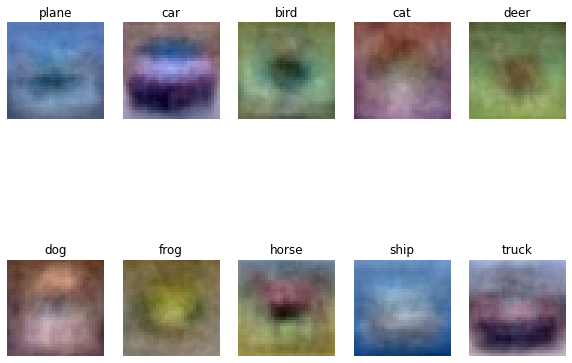

In [55]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])